In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

## Load In Images into an array

In [2]:
images = os.listdir('./cluedo_images')
img_arr = []

for image in images:
    img = cv.imread("./cluedo_images/" + image)
    # Convert the BRG image to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dim = (200, 300)
    # resize image
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    img_arr.append(img)

## Display the Cludo characters

In [3]:
def show_images(rows, cols , img_arr):
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

    for i in range(rows):
        for j in range(cols):        
            if img_count < len(images):
                axes[i, j].imshow(img_arr[img_count])
                axes[i,j].axis('off')
                img_count+=1

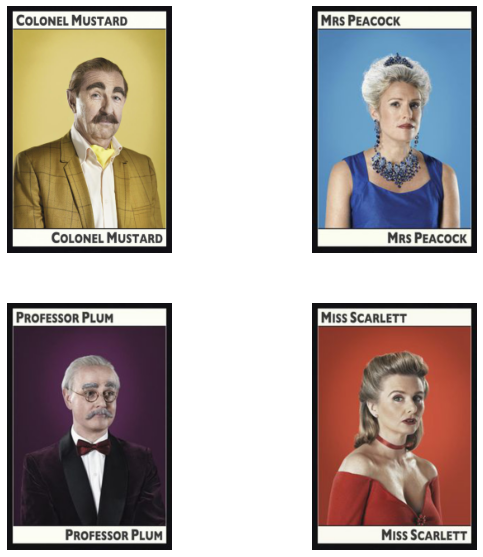

In [4]:
show_images(2,2,img_arr)

## K-Means + Proportions for Dominant Colour Extraction
Use k-means algorithim to extract the dominant colours from an image, then dispslay that data for all the cludo characters

In [5]:
from sklearn.cluster import KMeans
from collections import Counter


def k_means(num_of_colours):
    cluster = KMeans(n_clusters=num_of_colours)
    return cluster

cluster = k_means(5)

Display the colour pallate for the image

In [6]:
def colour_palette(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    #Number of pixels per cluster
    counter = Counter(k_cluster.labels_)
    col_proportions = {}
    for i in counter:
        col_proportions[i] = np.round(counter[i]/n_pixels, 2)
    
    #Sort the colours from largest to smallest
    col_proportions = dict(sorted(col_proportions.items() , key=lambda x: x[1] , reverse=True))
    
    print(col_proportions)
    
    ordered_cluster_centers = []
    
    #Order the colour clusters from largest to smallest
    for i, centers in enumerate(k_cluster.cluster_centers_):
        index = list(col_proportions)[i]
        ordered_cluster_centers.append(k_cluster.cluster_centers_[index])    
    
    step = 0
    for i, centers in enumerate(ordered_cluster_centers): 
            value = list(col_proportions.values())[i] #Proportion of each colour value
            palette[:, step:int(step + value*width+1), :] = centers
            step += int(value*width+1)
        
    return palette

{1: 0.34, 2: 0.21, 4: 0.17, 0: 0.15, 3: 0.14}
{0: 0.4, 3: 0.18, 4: 0.17, 2: 0.13, 1: 0.12}
{4: 0.43, 0: 0.33, 1: 0.11, 3: 0.07, 2: 0.05}
{3: 0.5, 2: 0.18, 0: 0.13, 4: 0.1, 1: 0.09}


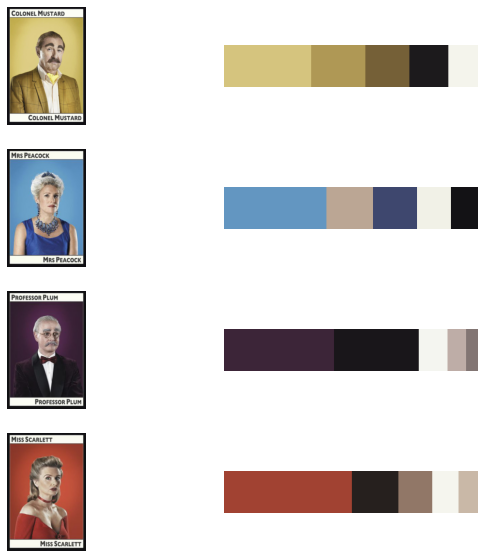

In [7]:
images = []

for image in img_arr:
    cluster = k_means(5)
    cluster = cluster.fit(image.reshape(-1, 3))
    images.append(image)
    images.append(colour_palette(cluster))

show_images(4,2,images)

In [8]:
import colorsys

def image_top_colours(k_cluster):
    n_pixels = len(k_cluster.labels_)
    #Number of pixels per cluster
    counter = Counter(k_cluster.labels_)
    col_proportions = {}
    for i in counter:
        col_proportions[i] = np.round(counter[i]/n_pixels, 2)
    
    #Sort the colours from largest to smallest
    col_proportions = dict(sorted(col_proportions.items() , key=lambda x: x[1] , reverse=True))
    
    ordered_cluster_centers = []
    
    #Order the colour clusters from largest to smallest
    for i, centers in enumerate(k_cluster.cluster_centers_):
        index = list(col_proportions)[i]
        ordered_cluster_centers.append(k_cluster.cluster_centers_[index])    
    
    # Convert the colours from RGB to HSV (full list)
#     for colour in ordered_cluster_centers:
#         print(colour)
#         h , s ,v = colorsys.rgb_to_hsv(colour[0]/255.,colour[1]/255.,colour[2]/255.)
#         h = int(h*360)
#         s = int(s*100)
#         v = int(v*100)
#         print(h,s,v)
    
    # Top colour converted to HSV
    rgb = ordered_cluster_centers[0]
    h , s ,v = colorsys.rgb_to_hsv(rgb[0]/255.,rgb[1]/255.,rgb[2]/255.)
    h = int(h*360)
    s = int(s*100)
    v = int(v*100)
    
    return h, list(col_proportions.values())[0]

In [9]:
# for image in img_arr:
#     cluster = k_means(5)
#     cluster = cluster.fit(image.reshape(-1, 3))
#     h , proportion = image_top_colours(cluster)
#     print(h, proportion)

Colour Identification

In [10]:
def colour_character_detection(image):
    conf_rating = 10
    mustard_h = 48
    peacock_h = 207
    plum_h = 309
    scralet_h = 8

    cluster = k_means(5)
    cluster = cluster.fit(image.reshape(-1, 3))
    h , proportion = image_top_colours(cluster)

    if (h > mustard_h-conf_rating and h < mustard_h+conf_rating):
        print("Image Contains: Colonel Mustard")

    elif (h > peacock_h-conf_rating and h < peacock_h+conf_rating):
        print("Image Contains: Mrs Peacock")

    elif (h > plum_h-conf_rating and h < plum_h+conf_rating):
        print("Image Contains: Professor Plum")

    elif (h > scralet_h-conf_rating and h < scralet_h+conf_rating):
        print("Image Contains: Miss Scarlett")
    else:
        print("Character Cannot be Identified by colour")
    

# Extracting the poster from an room image

Extract an image from a room using OpenCV contours

Number of shapes 3
Image Contains: Colonel Mustard


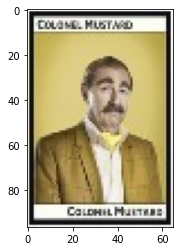

In [11]:
import random as rng
rng.seed(12345)

image = cv.imread('test_room.jpg')

src_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))
threshold = 300


# Detect edges using Canny
canny_output = cv.Canny(src_gray, threshold, threshold * 2)

# Find contours
contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)


print("Number of shapes {0}".format(len(contours)))

# Test to draw the bounding boxes
# drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
# for i in range(len(contours)):
#     color = (256,256,256)
#     cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
#     # Show in a window

for c in contours:
        if cv.contourArea(c) <= 50 :
            continue   
        x,y,w,h = cv.boundingRect(c)
        cv.rectangle(src_gray, (x, y), (x + w, y + h), (0, 255,0), 2)
        center = (x,y)
#         print (center)
#         print(x,y,w,h)

        
# Reload the image with croped dimensions
img = cv.imread('test_room.jpg')
img = cv.cvtColor(image, cv.COLOR_BGR2RGB)

img = img[y:y+h, x:x+w]
plt.imshow(img)

colour_character_detection(img)

# Data Agumentation

If we choose to train the model using YOLO5 here are the ways we can create more data for traning

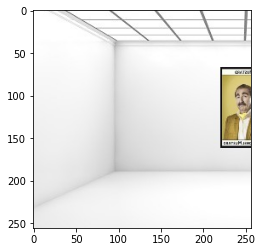

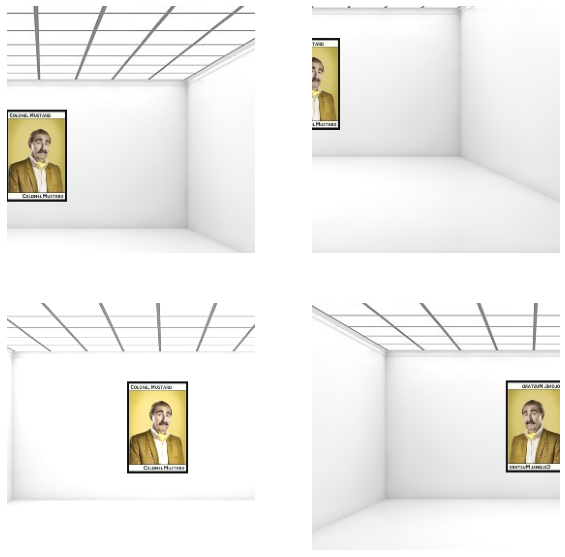

In [76]:
import albumentations as A

# Data Agumentation pipeline
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

image = cv.imread('test_room.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

augmented_images = []

for x in range(1, 10):
    transformed_img = transform(image=image)['image']
    augmented_images.append(transformed_img)

# plt.imshow(augmented_images[8])
show_images(2,2,augmented_images)